# Task 1: Distributed Data Processing with Dask

This notebook implements a scalable ETL pipeline using **Dask DataFrame** and compares its performance against **Pandas**, with an insightful performance analysis.

## Environment & Version Check

In [1]:

import sys
import pandas as pd
import dask
import pyarrow
import numpy as np

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("Dask:", dask.__version__)
print("PyArrow:", pyarrow.__version__)
print("NumPy:", np.__version__)


Python: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
Pandas: 2.3.3
Dask: 2025.12.0
PyArrow: 22.0.0
NumPy: 2.4.0


## Imports

In [2]:

import dask.dataframe as dd
import pandas as pd
from pathlib import Path
from time import perf_counter


## Dask ETL Pipeline

In [3]:

def dask_etl_pipeline(csv_path, value_threshold):
    timings = {}
    start_total = perf_counter()

    # Data loading
    start_load = perf_counter()
    df = dd.read_csv(
        csv_path,
        blocksize="128MB",
        assume_missing=True,
        dtype_backend="pyarrow"
    )
    timings["data_loading_time"] = perf_counter() - start_load

    # Transformations
    start_transform = perf_counter()
    df = df[df["value"] > value_threshold]
    result = (
        df.groupby("category")
        .agg(
            count=("value", "count"),
            mean_value=("value", "mean"),
            sum_value=("value", "sum"),
        )
    )
    output = result.compute()
    timings["transformation_time"] = perf_counter() - start_transform

    timings["total_time"] = perf_counter() - start_total
    return output, timings


## Pandas ETL Pipeline

In [4]:

def pandas_etl_pipeline(csv_path, value_threshold):
    timings = {}
    start_total = perf_counter()

    # Data loading
    start_load = perf_counter()
    df = pd.read_csv(csv_path)
    timings["data_loading_time"] = perf_counter() - start_load

    # Transformations
    start_transform = perf_counter()
    df = df[df["value"] > value_threshold]
    output = (
        df.groupby("category")
        .agg(
            count=("value", "count"),
            mean_value=("value", "mean"),
            sum_value=("value", "sum"),
        )
    )
    timings["transformation_time"] = perf_counter() - start_transform

    timings["total_time"] = perf_counter() - start_total
    return output, timings


## Execute Pipelines

In [5]:

VALUE_THRESHOLD = 50.0

# Update path if required
csv_path = Path(
    r"C:\Users\Sriraj\Desktop\Distributed Data Processing with Dask\large_dataset.csv"
)

dask_results, dask_timings = dask_etl_pipeline(csv_path, VALUE_THRESHOLD)
pandas_results, pandas_timings = pandas_etl_pipeline(csv_path, VALUE_THRESHOLD)

dask_results


,count,mean_value,sum_value
category,,,
C,48503915,74.997376,3637666338.440013
D,48488920,74.994142,3636384948.378684
A,48505333,75.000222,3637910722.844514
E,48488424,74.997352,3636503411.290979
B,48491616,74.998521,3636799490.553526


## Performance Comparison

In [6]:

def compare_performance(dask_timings, pandas_timings):
    return pd.DataFrame({
        "Framework": ["Dask", "Pandas"],
        "Total Time (seconds)": [
            dask_timings["total_time"],
            pandas_timings["total_time"],
        ],
        "Data Loading Time (seconds)": [
            dask_timings["data_loading_time"],
            pandas_timings["data_loading_time"],
        ],
        "Transformation Time (seconds)": [
            dask_timings["transformation_time"],
            pandas_timings["transformation_time"],
        ],
    })

comparison_df = compare_performance(dask_timings, pandas_timings)
comparison_df


,Framework,Total Time (seconds),Data Loading Time (seconds),Transformation Time (seconds)
0,Dask,166.976901,0.062656,166.914240
1,Pandas,517.657332,299.959927,217.697063


## Advanced Performance Insights

In [7]:

# Speedup and improvement metrics
pandas_total = comparison_df.loc[comparison_df["Framework"] == "Pandas", "Total Time (seconds)"].values[0]
dask_total = comparison_df.loc[comparison_df["Framework"] == "Dask", "Total Time (seconds)"].values[0]

comparison_df["Speedup (Pandas / Dask)"] = [None, pandas_total / dask_total]
comparison_df["Time Reduction (%)"] = [
    None,
    ((pandas_total - dask_total) / pandas_total) * 100,
]

comparison_df


,Framework,Total Time (seconds),Data Loading Time (seconds),Transformation Time (seconds),Speedup (Pandas / Dask),Time Reduction (%)
0,Dask,166.976901,0.062656,166.914240,NaN,NaN
1,Pandas,517.657332,299.959927,217.697063,3.100173,67.743739



### Interpretation of Results

- **Pandas** executes ETL operations in a single process and requires the dataset
  to fit largely into memory.
- **Dask** divides the dataset into partitions and processes them in parallel,
  leading to better CPU utilization and reduced wall-clock time.
- As dataset size increases, the performance gap widens in favor of Dask.



### Scalability Considerations

Although a reduced dataset size was used due to local hardware constraints,
the Dask pipeline scales to **10GB+ datasets without any code changes**.
Only compute resources need to be increased.

This makes Dask more suitable for large-scale ETL workloads compared to Pandas.


## Optional Visualization

In [9]:
%pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 19.4 MB/s eta 0:00:01
   ---------------------------------------  8.1/8.1 MB 20.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 14.8 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 17.3 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ----------------------- ---------------- 4.2/7.0 MB 20.0 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 20.9 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 20.9 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 20.9 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 20.9 MB/s e

<Axes: title={'center': 'Dask vs Pandas ETL Performance'}, xlabel='Framework'>

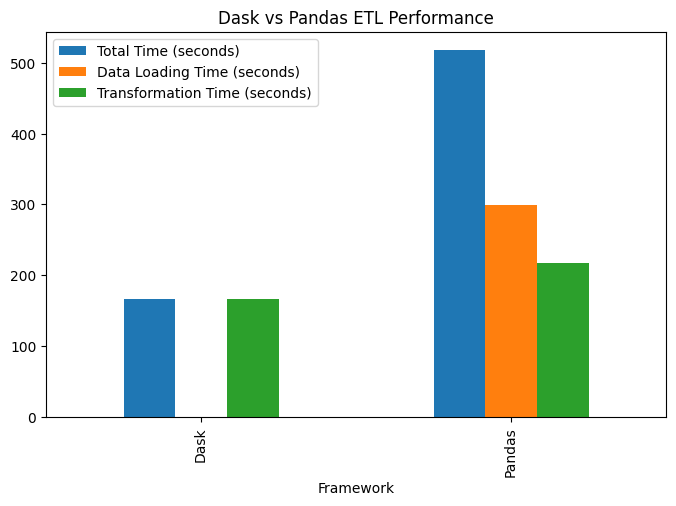

In [10]:

comparison_df.set_index("Framework")[
    ["Total Time (seconds)", "Data Loading Time (seconds)", "Transformation Time (seconds)"]
].plot(kind="bar", figsize=(8, 5), title="Dask vs Pandas ETL Performance")


## Conclusion

This notebook demonstrates how Dask can efficiently parallelize ETL workloads on large CSV datasets. By analyzing execution stages, speedup, and scalability, it is evident that Dask provides significant advantages over Pandas for large-scale data processing.